In [0]:
import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data.dataloader import DataLoader

import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
class SOM(nn.Module):
    def __init__(self, input_size, out_size=(10, 10), lr=0.3, sigma=None):
        '''
        :param input_size:
        :param out_size:
        :param lr:
        :param sigma:
        '''
        super(SOM, self).__init__()
        self.input_size = input_size
        self.out_size = out_size

        self.lr = lr
        if sigma is None:
            self.sigma = max(out_size) / 2
        else:
            self.sigma = float(sigma)

        self.weight = nn.Parameter(torch.randn(input_size, out_size[0] * out_size[1]), requires_grad=False)
        self.locations = nn.Parameter(torch.Tensor(list(self.get_map_index())), requires_grad=False)
        self.pdist_fn = nn.PairwiseDistance(p=2)

    def get_map_index(self):
        '''Two-dimensional mapping function'''
        for x in range(self.out_size[0]):
            for y in range(self.out_size[1]):
                yield (x, y)

    def _neighborhood_fn(self, input, current_sigma):
        '''e^(-(input / sigma^2))'''
        input.div_(current_sigma ** 2)
        input.neg_()
        input.exp_()

        return input

    def forward(self, input):
        '''
        Find the location of best matching unit.
        '''
        batch_size = input.size()[0]
        input = input.view(batch_size, -1, 1)
        batch_weight = self.weight.expand(batch_size, -1, -1)


        dists = self.pdist_fn(input, batch_weight)
        losses, bmu_indexes = dists.min(dim=1, keepdim=True)
        bmu_locations = self.locations[bmu_indexes]

        return bmu_locations, losses.sum().div_(batch_size).item()

    def self_organizing(self, input, current_iter, max_iter):
        '''
        Train the Self Oranizing Map(SOM)
        '''
        batch_size = input.size()[0]
        #Set learning rate
        iter_correction = 1.0 - current_iter / max_iter
        lr = self.lr * iter_correction
        sigma = self.sigma * iter_correction

        #Find best matching unit
        bmu_locations, loss = self.forward(input)

        distance_squares = self.locations.float() - bmu_locations.float()
        distance_squares.pow_(2)
        distance_squares = torch.sum(distance_squares, dim=2)

        lr_locations = self._neighborhood_fn(distance_squares, sigma)
        lr_locations.mul_(lr).unsqueeze_(1)

        delta = lr_locations * (input.unsqueeze(2) - self.weight)
        delta = delta.sum(dim=0)
        delta.div_(batch_size)
        self.weight.data.add_(delta)

        return loss

    def plot_result(self):
        '''
        Visualizes the weight of the Self Oranizing Map(SOM)
        '''
        images = self.weight.view(28, 28, self.out_size[0] * self.out_size[1])
        images = images.permute(2, 0, 1)

        images = images.cpu()
        _, axs = plt.subplots(self.out_size[0], self.out_size[1], figsize=(10, 10), 
                              gridspec_kw={'wspace':0, 'hspace':0}, squeeze=True)
        axs = axs.flatten()
        for img, ax in zip(images, axs):
            ax.axis('off')
            ax.imshow(img, interpolation='nearest', cmap='gray')
        plt.show()

In [0]:
# Load Data
transform = transforms.Compose([transforms.ToTensor()])
train_data = datasets.MNIST('data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
train_data.data = train_data.data[:10000]
train_data.targets = train_data.targets[:10000]

In [0]:
# Hyperparameters
batch_size = 32
total_epoch = 150
row = 30
col = 30

In [0]:
# Build Model
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
som = SOM(input_size=28 * 28 * 1, out_size=(row, col))
som = som.to(device)

========== Epoch 0 ==========


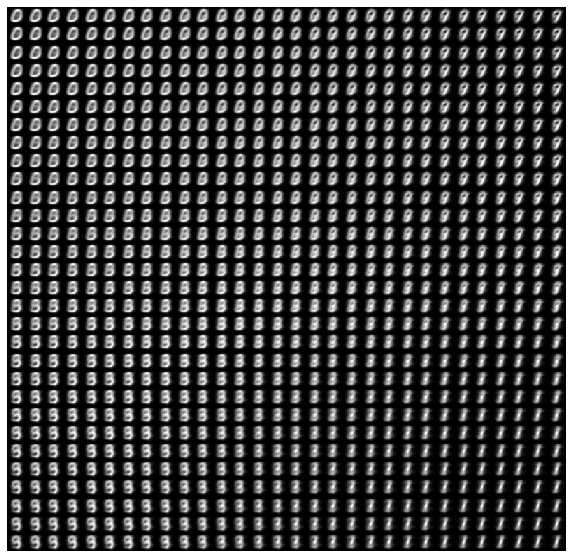

========== Epoch 10 ==========


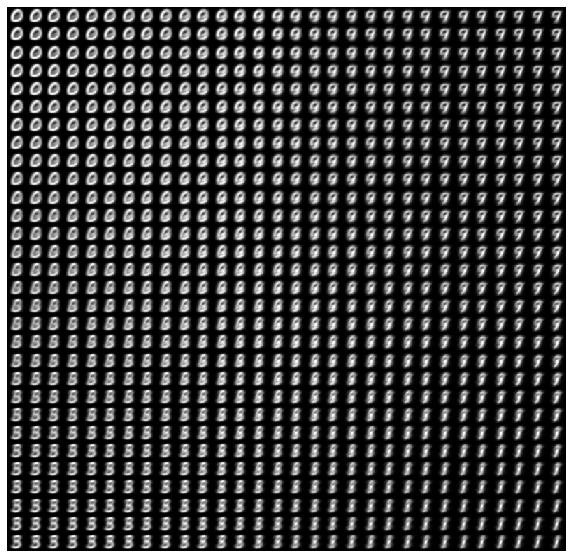

========== Epoch 20 ==========


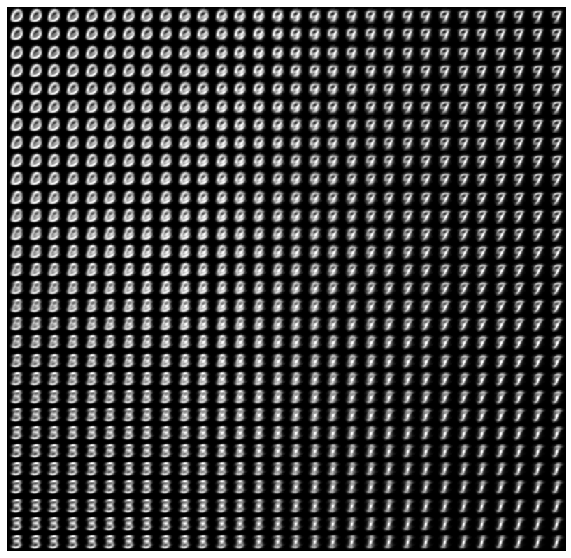

========== Epoch 30 ==========


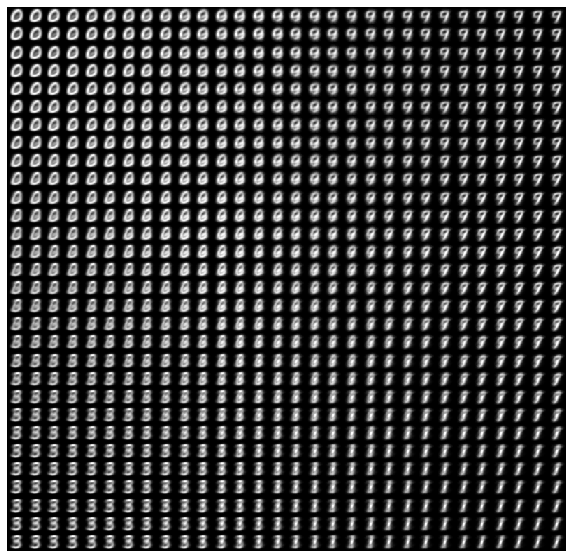

========== Epoch 40 ==========


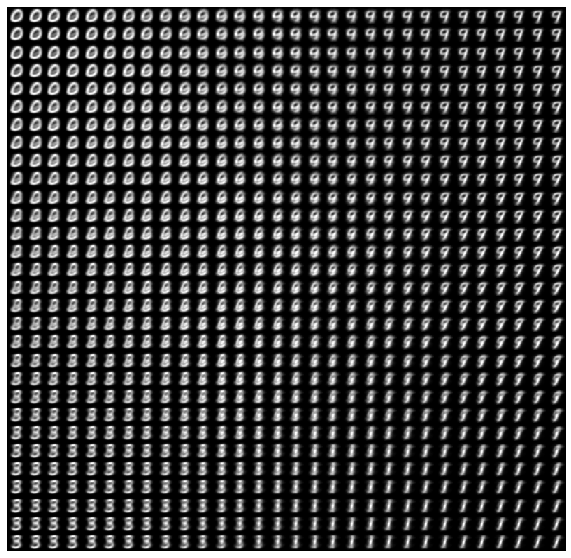

========== Epoch 50 ==========


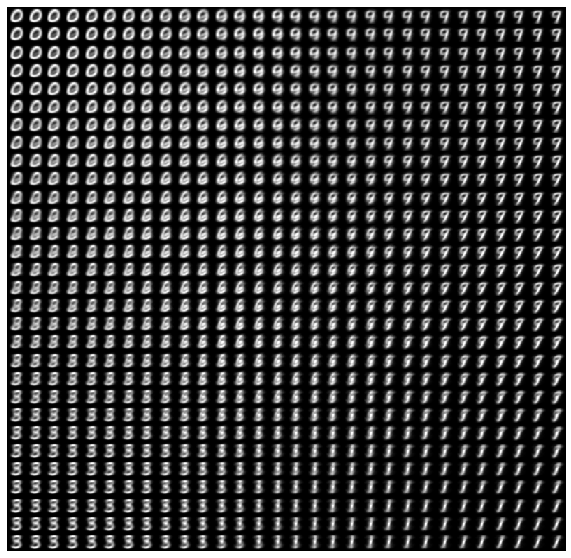

========== Epoch 60 ==========


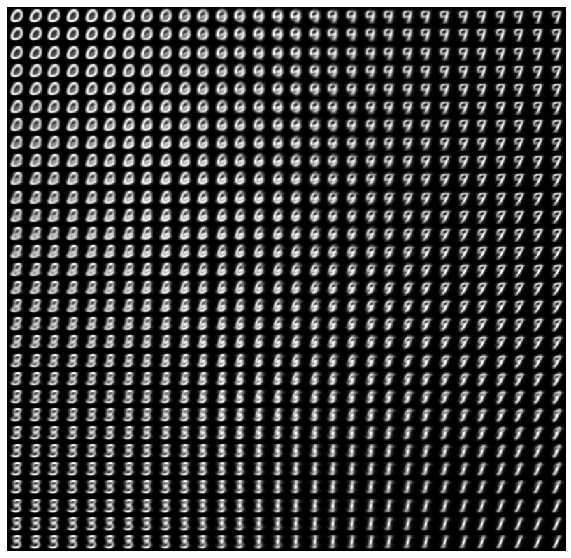

========== Epoch 70 ==========


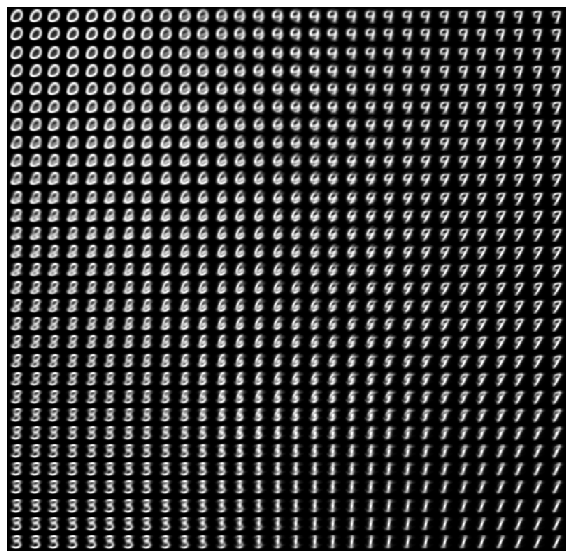

========== Epoch 80 ==========


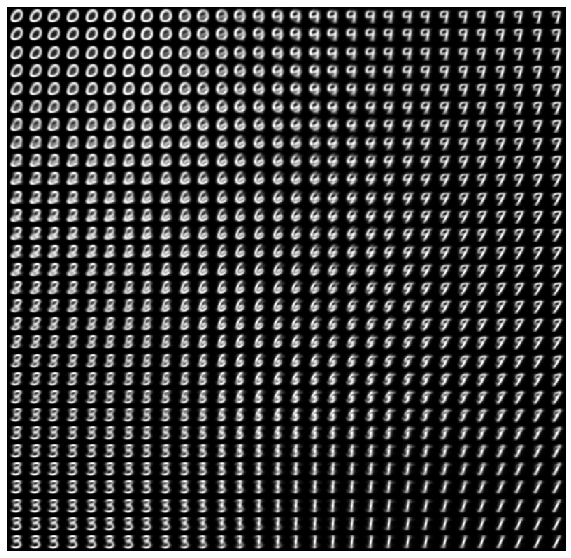

========== Epoch 90 ==========


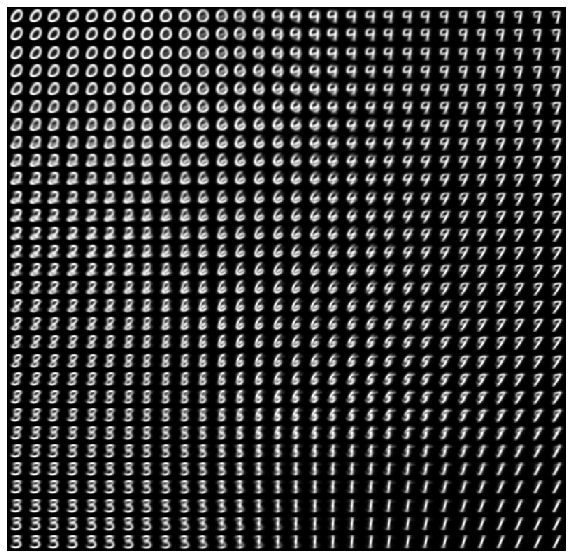

========== Epoch 100 ==========


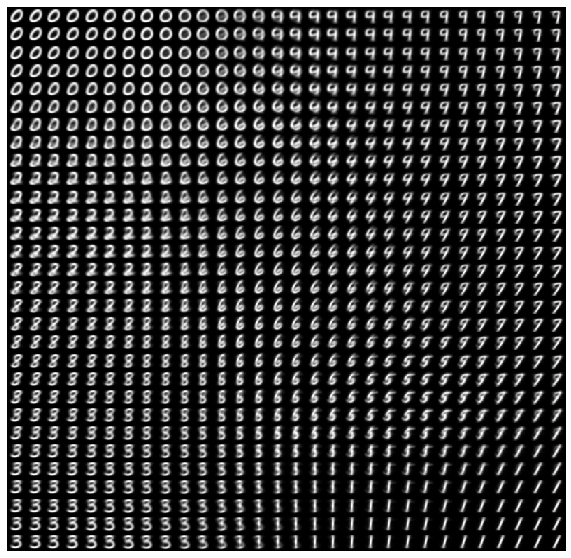

========== Epoch 110 ==========


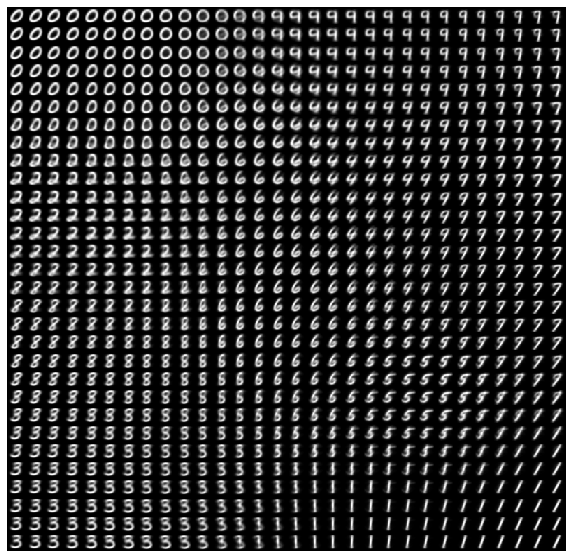

========== Epoch 120 ==========


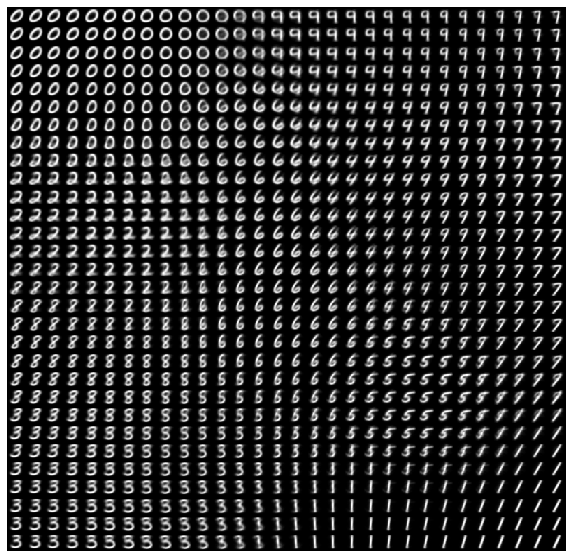

========== Epoch 130 ==========


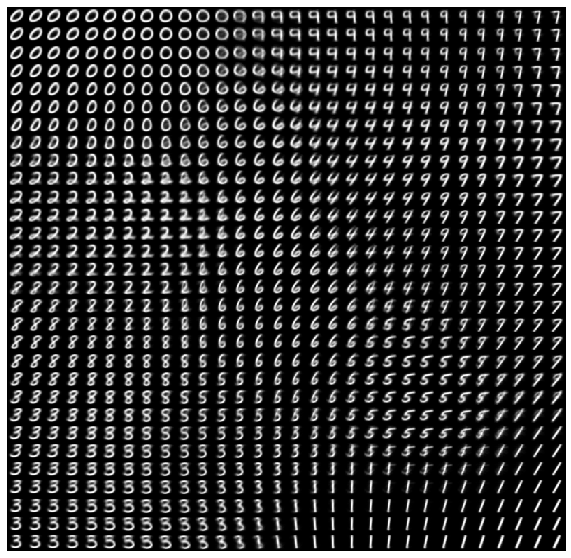

========== Epoch 140 ==========


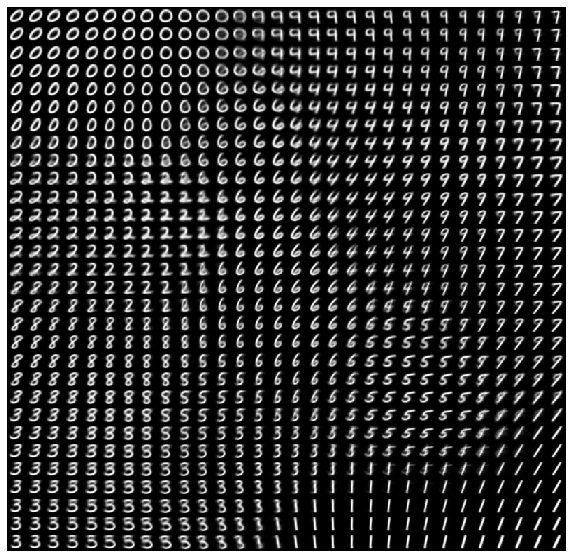

In [66]:
# Training
losses = list()
for epoch in range(total_epoch):
    running_loss = 0
    start_time = time.time()
    for idx, (X, Y) in enumerate(train_loader):
        X = X.view(-1, 28 * 28 * 1).to(device)    # flatten
        loss = som.self_organizing(X, epoch, total_epoch)    # train som
        running_loss += loss

    losses.append(running_loss)

    if epoch % 10 == 0:
        print("="*10 + f" Epoch {epoch} " + "="*10)
        images = som.plot_result()

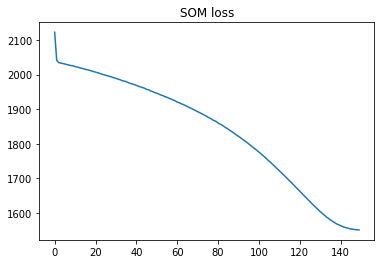

In [67]:
torch.save(som.state_dict(), 'som.pth')
plt.title('SOM loss')
plt.plot(losses)
plt.show()